You can download the dataset from [here](https://www.kaggle.com/tongpython/cat-and-dog).

From the original dataset, I have selected 1500 images of each cats and dogs and put in the training_set directory. And 250 images of each in the test_set directory.
That makes the dataset consisting of 3000 training examples and 500 test examples.

In [1]:
# Importing the libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
ROWS = 64
COLUMNS = 64
CHANNELS = 3

# Defining path for images
TRAIN_DIR = 'dataset/training_set/'
TEST_DIR = 'dataset/test_set/'

# Preparing filepath from the dataset
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [3]:
# Function to read image and convert to the specified size
def read_image(file_path):
    img = cv2.imread(file_path)
    return cv2.resize(img, (ROWS, COLUMNS), cv2.INTER_CUBIC)

In [4]:
def prepare_data(images):
    m = len(images)
    X = np.zeros((m, ROWS, COLUMNS, CHANNELS))
    y = np.zeros((1, m))
    
    for i, image_path in enumerate(images):
        X[i,:] = read_image(image_path)
        if 'cat' in image_path.lower():
            y[0,i] = 0
        elif 'dog' in image_path.lower():
            y[0,i] = 1
    return X, y

In [5]:
# Loading the data
train_set_X, train_set_y = prepare_data(train_images)
test_set_X, test_set_y = prepare_data(test_images)

In [6]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_X.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_X.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_X.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 3000
Number of testing examples: m_test = 500
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (3000, 64, 64, 3)
train_set_y shape: (1, 3000)
test_set_x shape: (500, 64, 64, 3)
test_set_y shape: (1, 500)


In [7]:
# Flattening the images in the dataset
train_set_X_flatten = train_set_X.reshape(train_set_X.shape[0], -1).T
test_set_X_flatten = test_set_X.reshape(test_set_X.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_X_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_X_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 3000)
train_set_y shape: (1, 3000)
test_set_x_flatten shape: (12288, 500)
test_set_y shape: (1, 500)


In [8]:
# Standardizing the dataset
train_set_X = train_set_X_flatten / 255.
test_set_X = test_set_X_flatten / 255.

## Building the parts of our algorithm
The main steps for building a Neural Network are:

1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    * Calculate current loss (forward propagation)
    * Calculate current gradient (backward propagation)
    * Update parameters (gradient descent)

### Helper Functions

#### 1. Sigmoid
Compute the sigmoid of z

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


#### 2. Initializing parameters
Using He initialization. This initializes the weights to random values scaled according to a paper by He et al., 2015.

In [11]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [12]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


#### 3. Forward and Backward propagation
Implement the cost function and its gradient

In [13]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION
    # compute activation
    z = np.dot(w.T, X) + b
    A = sigmoid(z)
    # compute cost
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    
    # BACKWARD PROPAGATION
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [14]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


#### 4. Optimization
This function optimizes w and b by running a gradient descent algorithm

In [15]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            
        # Print the cost every training examples
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
            
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [16]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


### Implementing the predict() function
1. Calculate y_hat.
2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5). Store the predictions in a vector y_prediction.

In [17]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,1] to actual predictions p[0,i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
                   
    return Y_prediction

In [18]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


### Merging all functions into a model

In [19]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [20]:
d = model(train_set_X, train_set_y, test_set_X, test_set_y, num_iterations = 2000, learning_rate = 0.0005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.685272
Cost after iteration 200: 0.680237
Cost after iteration 300: 0.676365
Cost after iteration 400: 0.673169
Cost after iteration 500: 0.670421
Cost after iteration 600: 0.667994
Cost after iteration 700: 0.665805
Cost after iteration 800: 0.663804
Cost after iteration 900: 0.661953
Cost after iteration 1000: 0.660227
Cost after iteration 1100: 0.658605
Cost after iteration 1200: 0.657074
Cost after iteration 1300: 0.655620
Cost after iteration 1400: 0.654236
Cost after iteration 1500: 0.652912
Cost after iteration 1600: 0.651642
Cost after iteration 1700: 0.650420
Cost after iteration 1800: 0.649243
Cost after iteration 1900: 0.648104
train accuracy: 64.53333333333333 %
test accuracy: 61.6 %


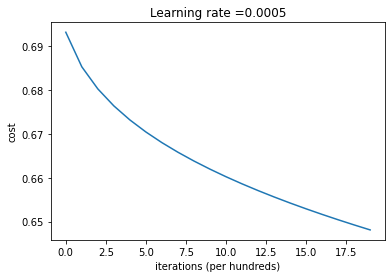

In [21]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### Testing with our own image

In [22]:
img_path = 'single_prediction/img1.jpg'

# Preprocessing image to fit our algorithm
my_img = read_image(img_path).reshape(1, ROWS*COLUMNS*CHANNELS).T
pred_img = predict(d["w"], d["b"], my_img)

# Printing the prediction. 0 for cat and 1 for dog.
print(np.squeeze(pred_img))

0.0


### Evaluating the model with different learning rates

learning rate is: 0.01
train accuracy: 55.16666666666667 %
test accuracy: 54.199999999999996 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 67.0 %
test accuracy: 58.6 %

-------------------------------------------------------

learning rate is: 0.0005
train accuracy: 64.53333333333333 %
test accuracy: 61.6 %

-------------------------------------------------------

learning rate is: 0.0003
train accuracy: 63.0 %
test accuracy: 60.8 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 60.66666666666667 %
test accuracy: 58.800000000000004 %

-------------------------------------------------------



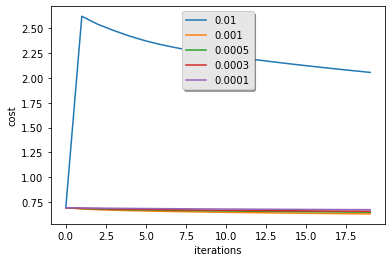

In [23]:
learning_rates = [0.01, 0.001, 0.0005, 0.0003, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_X, train_set_y, test_set_X, test_set_y, num_iterations = 2000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()